In [1]:
#import packages

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import numpy as np
import os
import scipy.stats as stats
from operator import itemgetter
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn import linear_model
from sklearn.feature_selection import f_regression
import seaborn as sns; sns.set(style="ticks", context = "paper", font = "Arial", font_scale = 1.9,
                               palette='colorblind', color_codes = True,
                               rc = {"font.size":7,
                                     "xtick.major.size": 2,
                                     "ytick.major.size": 2})
import warnings
warnings.filterwarnings('ignore')

In [2]:
#oChIEF sum intensity/vol

def sum_intensity_list (key1, key2):
    """formation of reference_list of all sample in all genotype"""

    def sum_intensity (key):
        """formation of reference_list of all sample in a particular genotype"""
        
        structure_path = "quantification/"+ key
        column_name = []
        sum_L_all = []
        sum_R_all = []

        for root, dirs, files in os.walk (structure_path):
            for file in files:
                if file.endswith ("rre_oChIEF_L_summary_b.csv"):#data will be avaiable after publication
                    file_l_path = os.path.join(root, "rre_oChIEF_L_summary_b.csv")#data will be avaiable after publication
                    folder_path = os.path.dirname(file_l_path)
                    path,folder_name = os.path.split(folder_path)
                    column_name.append (folder_name)
                    YFP_L = pd.read_csv (file_l_path, index_col = 0)
                    YFP_sum_L = []
                    file_al_path = os.path.join(root, "rre_area_L_summary.csv")#data will be avaiable after publication
                    area_L = pd.read_csv (file_al_path, index_col = 0)
                    total_YFP_L = YFP_L*(3240*4547)

                    for index_l, vara_l in total_YFP_L.iterrows():
                        sum_l = sum (total_YFP_L[total_YFP_L >=0].loc[index_l].dropna().values)
                        sum_area_l = sum (area_L[area_L >= 0].loc[index_l].dropna().values)
                        if sum_area_l >0:
                            YFP_mean_l = sum_l/sum_area_l
                        else:
                            YFP_mean_l=np.nan
                        YFP_sum_L.append (YFP_mean_l)
                    sum_L_all.append(YFP_sum_L)

                    YFP_R = pd.read_csv (os.path.join(root, "rre_oChIEF_R_summary_b.csv"), index_col = 0)#data will be avaiable after publication
                    YFP_sum_R = []
                    file_ar_path = os.path.join(root, "rre_area_R_summary.csv")#data will be avaiable after publication
                    area_R = pd.read_csv (file_ar_path, index_col = 0)
                    total_YFP_R = YFP_R*(3240*4547)

                    for index_r, vara_r in total_YFP_R.iterrows():
                        sum_r = sum (total_YFP_R[total_YFP_R >=0].loc[index_r].dropna().values)
                        sum_area_r = sum (area_R[area_R >= 0].loc[index_r].dropna().values)
                        if sum_area_r >0:
                            YFP_mean_r = sum_r/sum_area_r
                        else:
                            YFP_mean_r = np.nan                        
                        YFP_sum_R.append (YFP_mean_r)
                    sum_R_all.append(YFP_sum_R)
                    
        pd_YFP_l = pd.DataFrame (data = np.transpose (sum_L_all), index = total_YFP_L.index, columns = column_name)
        pd_YFP_r = pd.DataFrame (data = np.transpose (sum_R_all), index = total_YFP_R.index, columns = column_name)
        
        return (pd_YFP_l, pd_YFP_r)
    return (sum_intensity (key1), sum_intensity (key2))

WT, Tbr1 = sum_intensity_list ("WT", "Tbr1")


pd_oChIEF_wl, pd_oChIEF_wr = WT
pd_oChIEF_tl, pd_oChIEF_tr = Tbr1

pd_oChIEF_wl = pd_oChIEF_wl.dropna(axis=0)
pd_oChIEF_wr = pd_oChIEF_wr.dropna(axis=0)
pd_oChIEF_tl = pd_oChIEF_tl.dropna(axis=0)
pd_oChIEF_tr = pd_oChIEF_tr.dropna(axis=0)

#oChIEF mean intensitity average
pd_oChIEF_tl["average"] = pd_oChIEF_tl[pd_oChIEF_tl >= 0].mean(axis = 1)
pd_oChIEF_tr["average"] = pd_oChIEF_tr[pd_oChIEF_tr >= 0].mean(axis = 1)
pd_oChIEF_wl["average"] = pd_oChIEF_wl[pd_oChIEF_wl >= 0].mean(axis = 1)
pd_oChIEF_wr["average"] = pd_oChIEF_wr[pd_oChIEF_wr >= 0].mean(axis = 1)

#filter structure based on Tbr1 oChIEF average 20 percentile
Tbr1_average = pd_oChIEF_tl["average"].tolist()+pd_oChIEF_tr["average"].tolist()
cut_scale = np.percentile (Tbr1_average, 20)

In [3]:
#format oChIEF intensity data

#subset brain regions for oChIEF comparison
oChIEF_sum_L_list = []
index_sum_L= []

for indexa, varaa in pd_oChIEF_tl.iterrows():
    if indexa in pd_oChIEF_wl[pd_oChIEF_wl.average >cut_scale].index:
        oChIEF_sum_L_W = pd_oChIEF_wl["average"].loc[indexa]
        oChIEF_sum_L_T = pd_oChIEF_tl["average"].loc[indexa]
        
        if oChIEF_sum_L_W >0:
            
            oChIEF_ratio_L = (oChIEF_sum_L_T/oChIEF_sum_L_W)*100
            
            oChIEF_sum_L_list.append (oChIEF_ratio_L)
            index_sum_L.append (indexa)
            
oChIEF_sum_R_list = []
index_sum_R= []

for indexb, varab in pd_oChIEF_tr.iterrows():
    if indexb in pd_oChIEF_wr[pd_oChIEF_wr.average >cut_scale].index:
        oChIEF_sum_R_W = pd_oChIEF_wr["average"].loc[indexb]
        oChIEF_sum_R_T = pd_oChIEF_tr["average"].loc[indexb]
        
        if oChIEF_sum_R_W >0:
            
            oChIEF_ratio_R = (oChIEF_sum_R_T/oChIEF_sum_R_W)*100
            
            oChIEF_sum_R_list.append (oChIEF_ratio_R)
            index_sum_R.append (indexb)


oChIEF_summary_L = pd.DataFrame (data = oChIEF_sum_L_list, index =index_sum_L)
oChIEF_summary_R = pd.DataFrame (data = oChIEF_sum_R_list, index =index_sum_R)

index_L = [indexa for indexa, varaa in pd_oChIEF_tl.iterrows() if indexa in oChIEF_summary_L.index]
index_R = [indexa for indexa, varaa in pd_oChIEF_tr.iterrows() if indexa in oChIEF_summary_R.index]

pd_oChIEF_tl_compare = pd_oChIEF_tl.loc[index_L]
pd_oChIEF_wl_compare = pd_oChIEF_wl.loc[index_L]
pd_oChIEF_tr_compare = pd_oChIEF_tr.loc[index_R]
pd_oChIEF_wr_compare = pd_oChIEF_wr.loc[index_R]

##normalize to WT oChIEF average
for indexe, varae in pd_oChIEF_tl_compare.iterrows():
    
    pd_oChIEF_tl_compare.loc[indexe] = (pd_oChIEF_tl_compare.loc[indexe] / pd_oChIEF_wl_compare["average"].loc[indexe])*100
    pd_oChIEF_wl_compare.loc[indexe] = (pd_oChIEF_wl_compare.loc[indexe] / pd_oChIEF_wl_compare["average"].loc[indexe])*100 

for indexf, varaf in pd_oChIEF_tr_compare.iterrows():
    
    pd_oChIEF_tr_compare.loc[indexf] = (pd_oChIEF_tr_compare.loc[indexf] / pd_oChIEF_wr_compare["average"].loc[indexf])*100
    pd_oChIEF_wr_compare.loc[indexf] = (pd_oChIEF_wr_compare.loc[indexf] / pd_oChIEF_wr_compare["average"].loc[indexf])*100 
    
pd_oChIEF_wl_compare["Tbr1 average"] = pd_oChIEF_tl_compare["average"]
pd_oChIEF_wr_compare["Tbr1 average"] = pd_oChIEF_tr_compare["average"]

sort_pd_oChIEF_tl_compare = pd_oChIEF_tl_compare.sort_values (by =["average"], ascending = False)
sort_pd_oChIEF_wl_compare = pd_oChIEF_wl_compare.sort_values (by =["Tbr1 average"], ascending = False)
sort_pd_oChIEF_tr_compare = pd_oChIEF_tr_compare.sort_values (by =["average"], ascending = False)
sort_pd_oChIEF_wr_compare = pd_oChIEF_wr_compare.sort_values (by =["Tbr1 average"], ascending = False)

sort_pd_oChIEF_tl_compare_T = sort_pd_oChIEF_tl_compare.T.iloc[:-1]
sort_pd_oChIEF_tl_compare_T["Genotype"] = "Tbr1"
sort_pd_oChIEF_tr_compare_T = sort_pd_oChIEF_tr_compare.T.iloc[:-1]
sort_pd_oChIEF_tr_compare_T["Genotype"] = "Tbr1"

sort_pd_oChIEF_wl_compare_T = sort_pd_oChIEF_wl_compare.T.iloc[:-2]
sort_pd_oChIEF_wl_compare_T["Genotype"] = "WT"
sort_pd_oChIEF_wr_compare_T = sort_pd_oChIEF_wr_compare.T.iloc[:-2]
sort_pd_oChIEF_wr_compare_T["Genotype"] = "WT"

sort_oChIEF_contra = pd.concat ([sort_pd_oChIEF_wl_compare_T, sort_pd_oChIEF_tl_compare_T])
sort_oChIEF_contra = sort_oChIEF_contra.T.dropna().T
sort_oChIEF_ipsi = pd.concat ([sort_pd_oChIEF_wr_compare_T, sort_pd_oChIEF_tr_compare_T])
sort_oChIEF_ipsi = sort_oChIEF_ipsi.T.dropna().T

In [23]:
#subset brain regions

structure_list_parent_v1 = pd.read_csv ("CCFv3/structuretree/structure_list_paper.csv", index_col = 0)

def subseting_structure (pd, structure_list):
    """subseting parent or offspring brain structures"""
    pd_sub = pd[[a for a in pd.columns if a in structure_list.LABEL.values]]
    pd_sub["Genotype"] = pd.Genotype
    pd_sub["Sample"] = pd.index
    return pd_sub

parent_pd_oChIEF_L = subseting_structure(sort_oChIEF_contra, structure_list_parent_v1)
parent_pd_oChIEF_R = subseting_structure(sort_oChIEF_ipsi, structure_list_parent_v1)

parent_pd_oChIEF_L_sub = parent_pd_oChIEF_L.drop(["SSp", "SSp-n", "SSp-bfd", "SSp-ll",
                                                  "SSp-tr","SSp-un", "SSs", "VISam",
                                                  "cc", "fa", "ec", "ccb", "ccs"], axis = 1)
parent_pd_oChIEF_R_sub = parent_pd_oChIEF_R.drop(["SSp", "SSp-n", "SSp-bfd", "SSp-ll", "SSp-m", "SSp-ul",
                                                  "SSp-tr","SSp-un", "SSs", "VISam",
                                                  "LA", "BLA", "BLAa", "BLAp", "BLAv",
                                                  "cc", "fa", "ec", "ee", "ccg", "fp", "ccb", "ccs"], axis = 1)

In [24]:
#mannwhitney U test of oChIEF mean intensity
def U_test (Genotype1, Genotype2, data):
    """perform mannwhitney U test of oChIEF mean intensity between two genotypes"""
    statistic_list = []
    pvalue_list =[]
    ratio_list = []
    structure_list = []
    structure_rearrange = [a for a in structure_list_parent_v1.LABEL if a in data.columns]
            
    for e in data[structure_rearrange].columns:
        ratio = (data[data["Genotype"]==Genotype2][e].mean())/(data[data["Genotype"]==Genotype1][e].mean())
        U_test = stats.mannwhitneyu (data[data["Genotype"]==Genotype1][e].tolist(), data[data["Genotype"]==Genotype2][e].tolist(), alternative="two-sided")
        statistic_list.append (U_test[0])
        pvalue_list.append (U_test[1])
        ratio_list.append (ratio)
        structure_list.append (e)
    U_test_summary = pd.DataFrame ([statistic_list, pvalue_list, ratio_list, structure_list], index = ["U_test_statistic", "U_test_pvalue", "Ratio of oChIEF binarized mean intensity", "structure"], columns = data[structure_rearrange].columns).T
    
    return U_test_summary


U_test_parent_L = U_test ("WT", "Tbr1", parent_pd_oChIEF_L_sub)
U_test_parent_L["hemisphere"] = "contra"
U_test_parent_R = U_test ("WT", "Tbr1", parent_pd_oChIEF_R_sub)
U_test_parent_R["hemisphere"] = "ipsi"

#bain regions with ROI correction
structure_list_L = ["LA", "BLA", "amc", "VISam", "CP", "AI", "VISC", "ORBvl", "TEa", "AIp", "ORBl", "ACAd", "BLAa",
                    "AUD", "ACAv", "PL", "ILA", "RSPv", "RSPd", "RSPagl", "VISa", "MOs", "SSp-tr", "SSp-ll", "act", "ORBm", "PP",
                    "CM", "RH", "PCN", "PF", "CL", "PIL", "AUDd", "AUDv", "PVpo",
                    "RSP", "ORB", "ACA", "ILM", "AId", "VTA", "RE", "BLAp"]

structure_list_R = ["LA", "BLA", "ORBvl", "PBG", "SAG", "FRP", "APr", "VISam", "scp", "CP", "AI", "VISC", "TEa", "AIp", "ORBl", "ACAd", "BLAa",
                    "AUD", "ORBm", "ACAv", "PL", "ILA", "RSPv", "RSPd", "RSPagl", "VISa", "MOs", "SSp-tr", "SSp-ll", "PPN", "PP", "RCH", "ORBm",
                    "CM", "RH", "PCN", "PF", "CL", "PIL", "AUDd", "AUDv", "DG", "VTA",
                    "RSP", "ORB", "ACA", "ILM", "AId", "PVpo", "RE"]

U_test_parent_L["ROI correction"] = "No"
for a in U_test_parent_L.structure:
    if a in structure_list_L:
        U_test_parent_L["ROI correction"][a] = "Yes"
U_test_parent_R["ROI correction"] = "No"
for b in U_test_parent_R.structure:
    if b in structure_list_R:
        U_test_parent_R["ROI correction"][b] = "Yes"

U_Test_parent_all = pd.concat([U_test_parent_L, U_test_parent_R])
U_Test_parent_all["structure"] = U_Test_parent_all.index.tolist()

#format brain region color dict
def structure_color_dict (df):
    """construct structure color map"""
    cfos_structure_list = list(df["structure"])
    label_list = list(structure_list_parent_v1["LABEL"])
    label_dict = {si : i for i,si in enumerate(label_list)}
    index_list = list(itemgetter(*cfos_structure_list)(label_dict))
    color_list = structure_list_parent_v1.iloc[index_list][['-R-','-G-','-B-']]
    color_tuple = [tuple(x) for x in color_list.to_numpy()]
    color_code = ['#%02x%02x%02x' % (x) for x in color_tuple]
    structure_zip = zip(cfos_structure_list, color_code)
    structure_dict = dict(structure_zip)
    
    return structure_dict

U_Test_parent_all_color_dict = structure_color_dict(U_Test_parent_all)

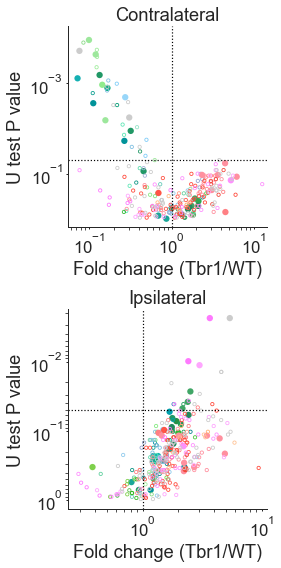

In [25]:
#plot Structure-wise comparison of binarized oChIEF signals between wild-type and Tbr1+/– mouse brains after volume-based quantification
#Figure 2c

contra_U_test_all = U_Test_parent_all[U_Test_parent_all["hemisphere"]=="contra"]
ipsi_U_test_all = U_Test_parent_all[U_Test_parent_all["hemisphere"]=="ipsi"]

markers = {"Yes": "o", "No": "$\circ$"}

plt.figure (figsize = (4,8))

plt.subplot (2, 1, 1)
ax = sns.scatterplot (data = contra_U_test_all, 
                     x = "Ratio of oChIEF binarized mean intensity",
                     y = "U_test_pvalue", 
                     hue = "structure",
                     palette = U_Test_parent_all_color_dict,
                     style = "ROI correction",
                     markers = markers,
                     legend = False, 
                     s = 40,
                     linewidth=0)
plt.ylabel ("U test P value")
plt.xlabel ("Fold change (Tbr1/WT)")
plt.axhline(y=0.05, color='black', linestyle=':')
plt.axvline(x=1, color='black', linestyle=':')
plt.title ("Contralateral")
ax.invert_yaxis()
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim([-0.5, contra_U_test_all["Ratio of oChIEF binarized mean intensity"].max()+2])
ax.set_ylim([1+0.5,contra_U_test_all["U_test_pvalue"].min()-contra_U_test_all["U_test_pvalue"].min()/2])

plt.subplot (2, 1, 2)
ax = sns.scatterplot (data = ipsi_U_test_all, 
                     x = "Ratio of oChIEF binarized mean intensity",
                     y = "U_test_pvalue", 
                     hue = "structure",
                     palette = U_Test_parent_all_color_dict,
                     style = "ROI correction",
                     markers = markers,
                     legend = False, 
                     s  = 40,
                     linewidth=0)
plt.ylabel ("U test P value")
plt.xlabel ("Fold change (Tbr1/WT)")
plt.axhline(y=0.05, color='black', linestyle=':')
plt.axvline(x=1, color='black', linestyle=':')
plt.title ("Ipsilateral")
ax.invert_yaxis()
ax.set_yscale("log")
ax.set_xscale("log")
plt.tight_layout()
sns.despine()
plt.show()

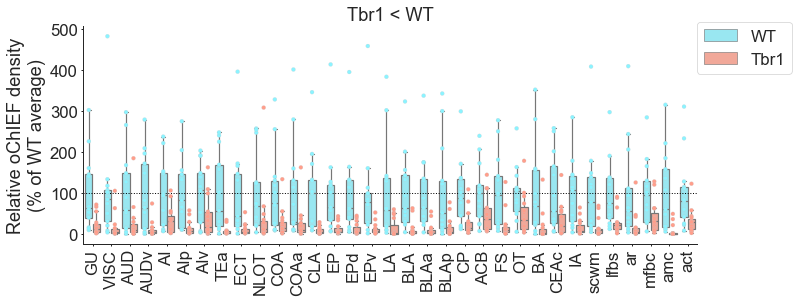

In [26]:
#Scatterplot showing the fold-change (Tbr1+/–/WT) versus significance (Mann-Whitney U test P value) of each contralateral brain region
#Figure 2d left panel

contra_U = contra_U_test_all[contra_U_test_all["U_test_pvalue"]<0.05]["structure"].tolist()
contra_list = [i for i in structure_list_parent_v1["LABEL"].tolist() if i in contra_U]
parent_pd_oChIEF_L_U = parent_pd_oChIEF_L[contra_list]
parent_pd_oChIEF_L_U["Genotype"] = parent_pd_oChIEF_L["Genotype"]
parent_pd_oChIEF_L_U["Sample"] = parent_pd_oChIEF_L["Sample"]
parent_contra_m = pd.melt (parent_pd_oChIEF_L_U,
                           ["Genotype", "Sample"],
                           var_name = "Structure",
                           value_name = "Relative oChIEF density""<br>""(% of WT average)")

plt.figure (figsize = (11,4))
ax = sns.stripplot (y = "Relative oChIEF density""<br>""(% of WT average)", 
               x = "Structure", 
               hue = "Genotype",
               size = 4, 
               data = parent_contra_m,
               palette = ["#8BF3FF", "#FF9E8B"],
               dodge=True, jitter = False, split = True, linewidth = 0.2, edgecolor = "#C8C8C8")
ax = sns.boxplot (y = "Relative oChIEF density""<br>""(% of WT average)", 
               x = "Structure", 
               hue = "Genotype", 
               data = parent_contra_m,
               palette = ["#8BF3FF", "#FF9E8B"],
               dodge=True, fliersize=0)
plt.axhline(y=100, color='black', linewidth=1, linestyle=':')
ax.set_xticklabels (ax.get_xticklabels(), rotation = "vertical")
ax.set_ylabel ("Relative oChIEF density\n(% of WT average)")
ax.set_title ("Tbr1 < WT")
ax.set_xlabel ("")
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[2:], labels[2:], bbox_to_anchor=(1, 1.02), loc=2, borderaxespad=0.)
sns.despine()
plt.show()

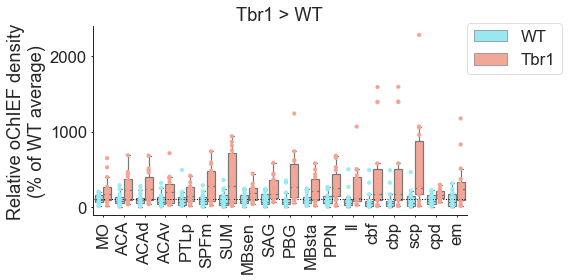

In [27]:
#Scatterplot showing the fold-change (Tbr1+/–/WT) versus significance (Mann-Whitney U test P value) of each ipsilateral brain region
#Figure 2d right panel
ipsi_U = ipsi_U_test_all[ipsi_U_test_all["U_test_pvalue"]<0.05]["structure"].tolist()
ipsi_list = [i for i in structure_list_parent_v1["LABEL"].tolist() if i in ipsi_U]
parent_pd_oChIEF_R_U = parent_pd_oChIEF_R[ipsi_list]
parent_pd_oChIEF_R_U["Genotype"] = parent_pd_oChIEF_R["Genotype"]
parent_pd_oChIEF_R_U["Sample"] = parent_pd_oChIEF_R["Sample"]
parent_ipsi_m = pd.melt (parent_pd_oChIEF_R_U,
                         ["Genotype", "Sample"],
                         var_name = "Structure",
                         value_name = "Relative oChIEF density""<br>""(% of WT average)")
plt.figure (figsize = (8,4))
sns.stripplot (y = "Relative oChIEF density""<br>""(% of WT average)", 
               x = "Structure", 
               hue = "Genotype", 
               size = 4,
               data = parent_ipsi_m,
               palette = ["#8BF3FF", "#FF9E8B"],
               dodge=True, jitter = False, split = True, linewidth = 0.2, edgecolor = "#C8C8C8")
ax = sns.boxplot (y = "Relative oChIEF density""<br>""(% of WT average)", 
               x = "Structure", 
               hue = "Genotype", 
               data = parent_ipsi_m,
               palette = ["#8BF3FF", "#FF9E8B"],
               dodge=True, fliersize=0)
plt.axhline(y=100, color='black', linewidth=1, linestyle=':')
plt.xticks (rotation = "vertical")
plt.ylabel ("Relative oChIEF density\n(% of WT average)")
plt.title ("Tbr1 > WT")
plt.xlabel ("")
ax2 = plt.gca()

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[2:], labels[2:], bbox_to_anchor=(1, 1.02), loc=2, borderaxespad=0.)
sns.despine()
plt.tight_layout()
plt.show()

In [28]:
#PCA analysis of oChIEF binarized mean intensity

slice_based_analysis = pd.read_csv ("table_s2.csv", index_col =0)
slice_oChIEF_contra_structure = slice_based_analysis["Contra. oChIEF Friedman test P value"].dropna().index.tolist()
slice_oChIEF_ipsi_structure = slice_based_analysis["Ipsi. oChIEF Friedman test P value"].dropna().index.tolist()

contra_list = list(set(parent_pd_oChIEF_L_sub.columns.tolist()).intersection(set(slice_oChIEF_contra_structure)))
ipsi_list = list(set(parent_pd_oChIEF_R_sub.columns.tolist()).intersection(set(slice_oChIEF_ipsi_structure)))
contra_structure_list = [s for s in structure_list_parent_v1.LABEL if s in contra_list]
ipsi_structure_list = [p for p in structure_list_parent_v1.LABEL if p in ipsi_list]
parent_pd_oChIEF_L_compare = parent_pd_oChIEF_L_sub[contra_structure_list]
parent_pd_oChIEF_R_compare = parent_pd_oChIEF_R_sub[ipsi_structure_list]

pipe = Pipeline ([("scaler", StandardScaler()), 
                ("reducer", PCA(n_components = 2))])

pipe2 = Pipeline ([("scaler", StandardScaler()), 
                ("reducer", PCA(n_components = 2))])

parent_oChIEF_L_pca = pipe.fit_transform(parent_pd_oChIEF_L_compare)
parent_oChIEF_R_pca = pipe2.fit_transform(parent_pd_oChIEF_R_compare)

PC_loading_contra = pd.DataFrame (data = {"PC1": pipe.steps[1][1].components_[0],
                                          "PC2": pipe.steps[1][1].components_[1]},
                                  index = parent_pd_oChIEF_L_compare.columns)
PC_loading_ipsi = pd.DataFrame (data = {"PC1": pipe2.steps[1][1].components_[0],
                                        "PC2": pipe2.steps[1][1].components_[1]}, 
                                index = parent_pd_oChIEF_R_compare.columns)

parent_pd_oChIEF_L["pcax"] = parent_oChIEF_L_pca[:,0]
parent_pd_oChIEF_L["pcay"] = parent_oChIEF_L_pca[:,1]

parent_pd_oChIEF_L["PC1 var(%)"] = pipe.steps[1][1].explained_variance_ratio_[0].round(2)*100
parent_pd_oChIEF_L["PC2 var(%)"] = pipe.steps[1][1].explained_variance_ratio_[1].round(2)*100

parent_pd_oChIEF_R["pcax"] = parent_oChIEF_R_pca[:,0]
parent_pd_oChIEF_R["pcay"] = parent_oChIEF_R_pca[:,1]

parent_pd_oChIEF_R["PC1 var(%)"] = pipe2.steps[1][1].explained_variance_ratio_[0].round(2)*100
parent_pd_oChIEF_R["PC2 var(%)"] = pipe2.steps[1][1].explained_variance_ratio_[1].round(2)*100

PCA_oChIEF_L = parent_pd_oChIEF_L.loc[:, ["pcax", "pcay", "PC1 var(%)", "PC2 var(%)"]]
PCA_oChIEF_L["Sample"]=parent_pd_oChIEF_L["Sample"]
PCA_oChIEF_L["Genotype"]= parent_pd_oChIEF_L["Genotype"]
PCA_oChIEF_L["hemisphere"]= "contra"
PCA_oChIEF_R = parent_pd_oChIEF_R.loc[:, ["pcax", "pcay", "PC1 var(%)", "PC2 var(%)"]]
PCA_oChIEF_R["Sample"]=parent_pd_oChIEF_R["Sample"]
PCA_oChIEF_R["Genotype"]= parent_pd_oChIEF_R["Genotype"]
PCA_oChIEF_R["hemisphere"]= "ipsi"

PCA_oChIEF = pd.concat ([PCA_oChIEF_L, PCA_oChIEF_R])

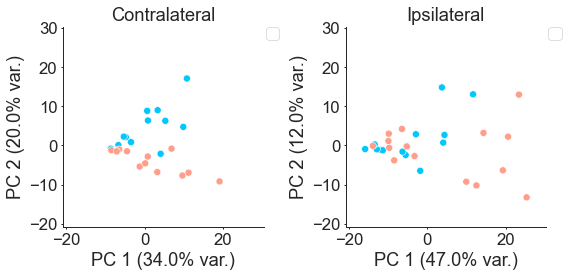

In [29]:
#plot oChIEF PC locations (Figure s5a, e)
plt.figure (figsize = (8,4))

plt.subplot (1,2,1)
sns.scatterplot (x ="pcax",
                 y ="pcay", 
                 hue = "Genotype", 
                 palette = ["#00C8FF", "#FF9E8B"],
                 data = PCA_oChIEF[PCA_oChIEF["hemisphere"]=="contra"], 
                 s = 50)
plt.xlabel ("PC 1 ({}% var.)".format(pipe.steps[1][1].explained_variance_ratio_[0].round(2)*100))
plt.ylabel ("PC 2 ({}% var.)".format(pipe.steps[1][1].explained_variance_ratio_[1].round(2)*100))
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:0], labels[0:0], bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
ax.set_aspect ("equal")
ax.set_xlim([PCA_oChIEF["pcax"].min()-5,PCA_oChIEF["pcax"].max()+5])
ax.set_ylim([PCA_oChIEF["pcax"].min()-5,PCA_oChIEF["pcax"].max()+5])
plt.title ("Contralateral")

plt.subplot (1,2,2)
sns.scatterplot (x ="pcax",
                 y ="pcay", 
                 hue = "Genotype",
                 palette = ["#00C8FF", "#FF9E8B"],
                 data = PCA_oChIEF[PCA_oChIEF["hemisphere"]=="ipsi"], s = 50)
plt.xlabel ("PC 1 ({}% var.)".format(pipe2.steps[1][1].explained_variance_ratio_[0].round(2)*100))
plt.ylabel ("PC 2 ({}% var.)".format(pipe2.steps[1][1].explained_variance_ratio_[1].round(2)*100))
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:0], labels[0:0], bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
ax.set_aspect ("equal")
ax.set_xlim([PCA_oChIEF["pcax"].min()-5,PCA_oChIEF["pcax"].max()+5])
ax.set_ylim([PCA_oChIEF["pcax"].min()-5,PCA_oChIEF["pcax"].max()+5])
sns.despine()
plt.title ("Ipsilateral")
plt.tight_layout()
plt.show()

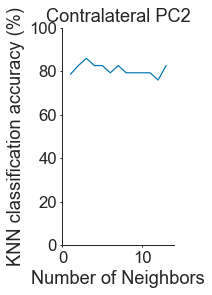

In [30]:
#KNN classification accuracy versus neighbors number
#Example: Figure s5b right panel

contra = PCA_oChIEF[PCA_oChIEF["hemisphere"]=="contra"]
contra_ml = contra[["pcay", "Genotype"]]

y = contra_ml["Genotype"].values
X = contra_ml.drop("Genotype", axis = 1).values

neighbors = np.arange (1,14)
test_accuracy = np.empty(len(neighbors))

for i, k in enumerate (neighbors):
    knn = KNeighborsClassifier(n_neighbors= k)
    cv_results = cross_validate (knn, X, y, cv = 5)
    test_accuracy[i] = np.mean(cv_results["test_score"])

fig, ax = plt.subplots (figsize = (2,4))
ax.plot (neighbors, test_accuracy*100)
ax.set_ylim([0, 100])
ax.set_xlim([0,14])
plt.xlabel ("Number of Neighbors")
plt.ylabel ("KNN classification accuracy (%)")
plt.title("Contralateral PC2")
sns.despine()

plt.show()

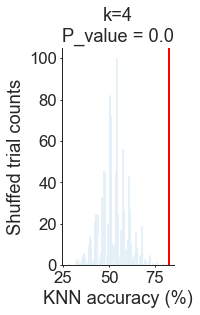

In [31]:
#real classification accuracy (indicated by the red line) with the classification accuracy distributions of PC locations shuffled 1000-times
#Example: Figure s5b right panel
contra= PCA_oChIEF[PCA_oChIEF["hemisphere"]=="contra"]
contra_ml = contra[["pcay", "Genotype"]]

y = contra_ml["Genotype"].values
X = contra_ml.drop("Genotype", axis = 1).values

knn = KNeighborsClassifier(n_neighbors= 4)
cv_results = cross_validate (knn, X, y, cv = 5)
exp_score = np.mean(cv_results["test_score"])

np.random.seed(17)
perm_knn_score = np.empty (1000)
for i in range (1000):
    perm_y = np.random.permutation(y)
    knn_perm = KNeighborsClassifier(n_neighbors= 4)
    cv_perm_results = cross_validate (knn_perm, X, perm_y, cv = 5)
    perm_knn_score[i] = np.mean(cv_perm_results["test_score"])

P = len([a for a in perm_knn_score if a>exp_score])/len(perm_knn_score)

plt.figure (figsize = (2,4))
plt.hist (perm_knn_score*100, bins = len (np.unique(perm_knn_score)))
plt.axvline(x=exp_score*100, color="red", linewidth=2)
plt.xlabel ("KNN accuracy (%)")
plt.ylabel ("Shuffed trial counts")
plt.title ("k=4\nP_value = {}".format (P))
sns.despine()
plt.show()

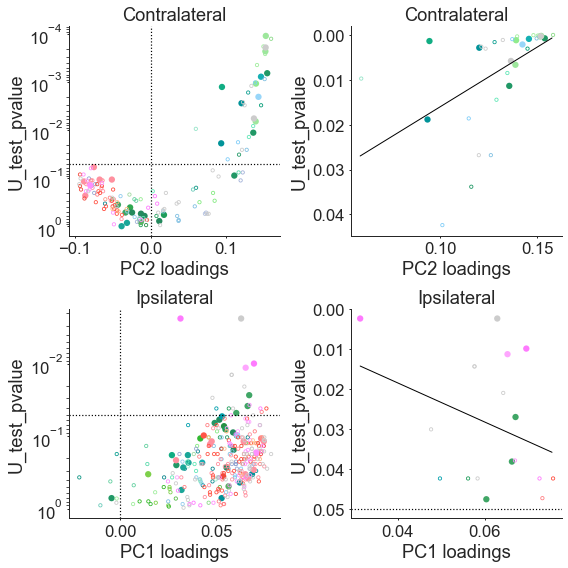

In [32]:
#correlation of U test P value and PC loadings (Figure s5c, g)


contra_U = contra_U_test_all.loc[contra_structure_list]
ipsi_U = ipsi_U_test_all.loc[ipsi_structure_list]
contra_U["PC2 loadings"] = PC_loading_contra["PC2"].tolist()
ipsi_U["PC1 loadings"] = PC_loading_ipsi["PC1"].tolist()

ipsi_U_sig = ipsi_U[ipsi_U["U_test_pvalue"]<0.05]
contra_U_sig = contra_U[contra_U["U_test_pvalue"]<0.05]

def linear_reg (df1, df2):
    reg = linear_model.LinearRegression()
    reg.fit (df1.values.reshape(-1,1), df2.values.reshape(-1,1))
    predication_space = np.linspace(min (df1.values.reshape(-1,1)), max(df1.values.reshape(-1,1)), len (df1.values.reshape(-1,1)))

    return reg, predication_space

ipsi_U_reg, ipsi_U_prediction_space = linear_reg (ipsi_U_sig["PC1 loadings"], ipsi_U_sig["U_test_pvalue"])
contra_U_reg, contra_U_prediction_space = linear_reg (contra_U_sig["PC2 loadings"], contra_U_sig["U_test_pvalue"])


markers = {"Yes": "o", "No": "$\circ$", }

plt.figure (figsize = (8,8))
plt.subplot (2, 2, 1)
ax = sns.scatterplot (data = contra_U, 
                     x = "PC2 loadings",
                     y = "U_test_pvalue", 
                     hue = "structure",
                     palette = U_Test_parent_all_color_dict,
                     style = "ROI correction",
                     markers = markers,
                     legend = False, 
                     s = 40,
                     linewidth=0)

plt.axhline(y=0.05, color='black', linestyle=':')
plt.axvline(x=0, color='black', linestyle=':')
ax.invert_yaxis()
ax.set_yscale("log")
plt.title ("Contralateral")

plt.subplot (2, 2, 2)
ax = sns.scatterplot (data = contra_U_sig, 
                     x = "PC2 loadings",
                     y = "U_test_pvalue", 
                     hue = "structure",
                     palette = U_Test_parent_all_color_dict,
                     style = "ROI correction",
                     markers = markers,
                     legend = False, 
                     s = 40,
                     linewidth=0)
plt.plot (contra_U_prediction_space, contra_U_reg.predict (contra_U_prediction_space), color="black", linewidth=1)
ax.invert_yaxis()

plt.title ("Contralateral")

plt.subplot (2, 2, 3)
ax = sns.scatterplot (data = ipsi_U, 
                     x = "PC1 loadings",
                     y = "U_test_pvalue", 
                     hue = "structure",
                     palette = U_Test_parent_all_color_dict,
                     style = "ROI correction",
                     markers = markers,
                     legend = False, 
                     s = 40,
                     linewidth=0)
plt.axhline(y=0.05, color='black', linestyle=':')
plt.axvline(x=0, color='black', linestyle=':')
ax.invert_yaxis()
ax.set_yscale("log")
plt.title ("Ipsilateral")

plt.subplot (2, 2, 4)
ax = sns.scatterplot (data = ipsi_U_sig, 
                     x = "PC1 loadings",
                     y = "U_test_pvalue", 
                     hue = "structure",
                     palette = U_Test_parent_all_color_dict,
                     style = "ROI correction",
                     markers = markers,
                     legend = False, 
                     s = 40,
                     linewidth=0)
plt.plot (ipsi_U_prediction_space, ipsi_U_reg.predict (ipsi_U_prediction_space), color="black", linewidth=1)
plt.axhline(y=0.05, color='black', linestyle=':')
#plt.axvline(x=0, color='black', linestyle=':')
ax.invert_yaxis()
plt.title ("Ipsilateral")
plt.tight_layout()
sns.despine()

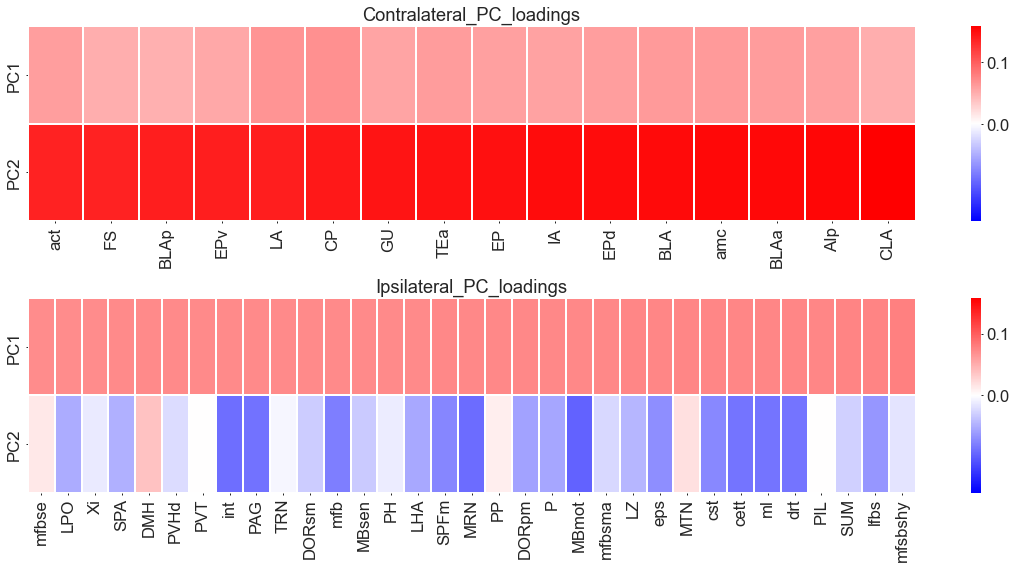

In [33]:
#Top 10% PC loadings (Figure s5d, h)
PC_loading_c = PC_loading_contra.sort_values(by="PC2").T
PC_loading_i = PC_loading_ipsi.sort_values(by="PC1").T

top10_c = np.percentile (abs(PC_loading_c.T["PC2"]), 90)
top10_i = np.percentile (abs(PC_loading_i.T["PC1"]), 90)

PC_loading_c_top10 = PC_loading_c.T[abs(PC_loading_c.T["PC2"])>top10_c].T
PC_loading_i_top10 = PC_loading_i.T[abs(PC_loading_i.T["PC1"])>top10_i].T

divnorm_PC2 = colors.TwoSlopeNorm(vmin=min (PC_loading_c.T["PC2"]), vcenter=0, vmax=max (PC_loading_c.T["PC2"]))

plt.figure (figsize = (16,8))

plt.subplot (2,1,1)
sns.heatmap (PC_loading_c_top10, cmap = "bwr", 
             norm = divnorm_PC2, 
             linewidths = 0.2,
             linecolor = "white")
plt.title ("Contralateral_PC_loadings")
plt.xticks(rotation=90)

plt.subplot (2,1,2)
sns.heatmap (PC_loading_i_top10, cmap = "bwr",
             norm = divnorm_PC2, 
             linewidths = 0.2,
             linecolor = "white")
plt.title ("Ipsilateral_PC_loadings")
plt.tight_layout()
plt.show()

In [34]:
#analysis of bilateral projection intensity ratio
pd_oChIEF_wl_re = pd_oChIEF_wl.iloc[:,:-1]
pd_oChIEF_wr_re = pd_oChIEF_wr.iloc[:,:-1]
pd_oChIEF_tl_re = pd_oChIEF_tl.iloc[:,:-1]
pd_oChIEF_tr_re = pd_oChIEF_tr.iloc[:,:-1]

bilateral_structure = [s for s in parent_pd_oChIEF_L_sub.columns if s in parent_pd_oChIEF_R_sub.columns]

Tbr1_bilateral_compare = pd_oChIEF_tl_re.loc[bilateral_structure[:-2]]/pd_oChIEF_tr_re.loc[bilateral_structure[:-2]]
WT_bilateral_compare = pd_oChIEF_wl_re.loc[bilateral_structure[:-2]]/pd_oChIEF_wr_re.loc[bilateral_structure[:-2]]

Tbr1_bilateral_compare_real = Tbr1_bilateral_compare.dropna().T
WT_bilateral_compare_real = WT_bilateral_compare.dropna().T

for a in WT_bilateral_compare_real.columns:
    WT_bilateral_compare_real[a].replace(0, np.nan, inplace = True)

WT_bilateral_compare_allreal = WT_bilateral_compare_real.dropna(axis =1)
Tbr1_bilateral_compare_allreal = Tbr1_bilateral_compare_real[WT_bilateral_compare_allreal.columns.tolist()]

WT_bilateral_compare_allreal_average = WT_bilateral_compare_allreal.mean(axis = 0)
Tbr1_bilateral_compare_allreal_ =Tbr1_bilateral_compare_allreal.mean(axis = 0)

for indexa, varaa in WT_bilateral_compare_allreal.iterrows():
    WT_bilateral_compare_allreal.loc[indexa] = WT_bilateral_compare_allreal.loc[indexa]/WT_bilateral_compare_allreal_average
for indexb, varab in Tbr1_bilateral_compare_allreal.iterrows():
    Tbr1_bilateral_compare_allreal.loc[indexb] = Tbr1_bilateral_compare_allreal.loc[indexb]/WT_bilateral_compare_allreal_average

WT_bilateral_compare_allreal["Sample"] = WT_bilateral_compare_allreal.index
WT_bilateral_compare_allreal["Genotype"] = "WT"
Tbr1_bilateral_compare_allreal["Sample"] = Tbr1_bilateral_compare_allreal.index
Tbr1_bilateral_compare_allreal["Genotype"] = "Tbr1"

bilateral_compare = pd.concat ([WT_bilateral_compare_allreal, Tbr1_bilateral_compare_allreal])

def U_test_bi (Genotype1, Genotype2, data):
    """perform mannwhitney U test of oChIEF mean intensity ratio between two hemisphere of two genotypes"""
    statistic_list = []
    pvalue_list =[]
    ratio_list = []
    structure_list = []
    structure_rearrange = []
    for a in structure_list_parent_v1.LABEL:
        if a in data.columns:
            structure_rearrange.append (a)
            
    for e in data[structure_rearrange].columns:
        ratio = (data[data["Genotype"]==Genotype2][e].mean())/(data[data["Genotype"]==Genotype1][e].mean())
        U_test = stats.mannwhitneyu (data[data["Genotype"]==Genotype1][e].tolist(), data[data["Genotype"]==Genotype2][e].tolist(), alternative="two-sided")
        statistic_list.append (U_test[0])
        pvalue_list.append (U_test[1])
        ratio_list.append (ratio)
        structure_list.append (e)
    U_test_summary = pd.DataFrame ([statistic_list, pvalue_list, ratio_list, structure_list], index = ["U_test_statistic", "U_test_pvalue", "Fold change (Tbr1/WT)", "structure"], columns = data[structure_rearrange].columns).T
    
    return U_test_summary

structure_list = ["LA", "BLA", "VISam", "CP", "AI", "VISC", "ORBvl", "TEa", "AIp", "ORBl", "ACAd", "BLAa",
                  "AUD", "ACAv", "PL", "ILA", "RSPv", "RSPd", "RSPagl", "VISa", "MOs", "SSp-tr", "SSp-ll", "ORBm", "PP",
                  "CM", "RH", "PCN", "PF", "CL", "PIL", "AUDd", "AUDv",
                  "RSP", "ORB", "ACA", "ILM", "AId", "VTA", "RE"]

structure_list_Tbr1_vol = ["aco", "cc", "FS", "AON", "PRE", "PAR", "ORBm", "CA1", "SUB"]

U_test_bilateral = U_test_bi ("WT", "Tbr1", bilateral_compare)
U_test_bilateral["ROI correction"] = "No"
for b in U_test_bilateral.structure:
    if b in structure_list:
        U_test_bilateral["ROI correction"][b] = "Yes"

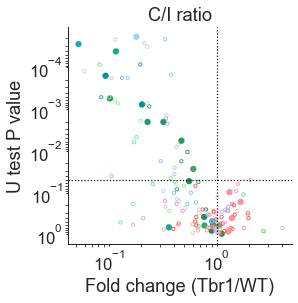

In [35]:
#plot bilateral projection intensity ratio comparison (Figure s4a)
markers = {"Yes": "o", "No": "$\circ$"}

plt.figure (figsize = (4,4))

ax = sns.scatterplot (data = U_test_bilateral, 
                     x = "Fold change (Tbr1/WT)",
                     y = "U_test_pvalue", 
                     hue = "structure",
                     palette = U_Test_parent_all_color_dict,
                     style = "ROI correction",
                     markers = markers,
                     legend = False, 
                     s = 40,
                     linewidth=0)
plt.ylabel ("U test P value")
plt.xlabel ("Fold change (Tbr1/WT)")
plt.axhline(y=0.05, color='black', linestyle=':')
plt.axvline(x=1, color='black', linestyle=':')
plt.title ("C/I ratio")
ax.invert_yaxis()
ax.set_yscale("log")
ax.set_xscale("log")
sns.despine()
plt.show()

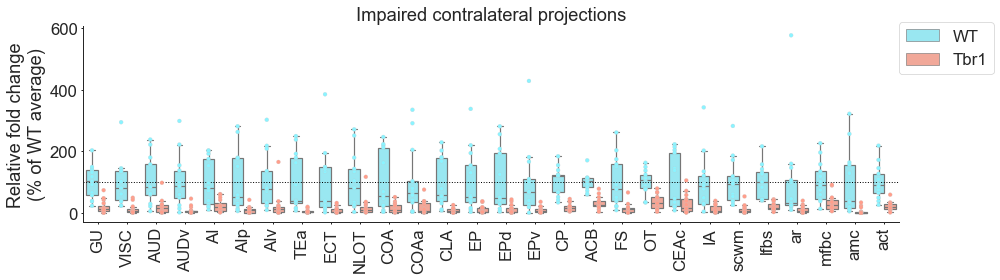

In [36]:
#plot bilateral changes individual regions contralateral (Figure s4b)
bilateral_U_list = U_test_bilateral[U_test_bilateral["U_test_pvalue"]<0.05]["structure"].tolist()
U_test_contra_list = U_test_parent_L[U_test_parent_L["U_test_pvalue"]<0.05]["structure"].tolist()
U_test_ipsi_list = U_test_parent_R[U_test_parent_R["U_test_pvalue"]<0.05]["structure"].tolist()


contra_U_bilateral = [a for a in U_test_contra_list if a in bilateral_U_list]
ipsi_U_bilateral = [a for a in U_test_ipsi_list if a in bilateral_U_list]
other_U_bilateral = [a for a in bilateral_U_list if (a not in contra_U_bilateral)&(a not in ipsi_U_bilateral)]

bilateral_compare_contra_U_bilateral =bilateral_compare[contra_U_bilateral]*100
bilateral_compare_contra_U_bilateral["Genotype"] = bilateral_compare["Genotype"]
bilateral_compare_contra_U_bilateral["Sample"] = bilateral_compare["Sample"]

bilateral_compare_ipsi_U_bilateral =bilateral_compare[ipsi_U_bilateral]*100
bilateral_compare_ipsi_U_bilateral["Genotype"] = bilateral_compare["Genotype"]
bilateral_compare_ipsi_U_bilateral["Sample"] = bilateral_compare["Sample"]

bilateral_compare_other_U_bilateral =bilateral_compare[other_U_bilateral]*100
bilateral_compare_other_U_bilateral["Genotype"] = bilateral_compare["Genotype"]
bilateral_compare_other_U_bilateral["Sample"] = bilateral_compare["Sample"]

bilateral_compare_contra_U_bilateral_m = pd.melt (bilateral_compare_contra_U_bilateral, 
                                                  ["Genotype", "Sample"],
                                                  var_name = "Structure",
                                                  value_name = "Fold change (Tbr1/WT)")

bilateral_compare_ipsi_U_bilateral_m = pd.melt (bilateral_compare_ipsi_U_bilateral, 
                                                  ["Genotype", "Sample"],
                                                  var_name = "Structure",
                                                  value_name = "Fold change (Tbr1/WT)")

bilateral_compare_other_U_bilateral_m = pd.melt (bilateral_compare_other_U_bilateral, 
                                                  ["Genotype", "Sample"],
                                                  var_name = "Structure",
                                                  value_name = "Fold change (Tbr1/WT)")

plt.figure (figsize = (14,4))
sns.stripplot (y = "Fold change (Tbr1/WT)", 
               x = "Structure", 
               hue = "Genotype", 
               size = 4,
               data = bilateral_compare_contra_U_bilateral_m,
               palette = ["#8BF3FF", "#FF9E8B"],
               dodge=True, jitter = False, split = True, linewidth = 0.2, edgecolor = "#C8C8C8")
ax = sns.boxplot (y = "Fold change (Tbr1/WT)", 
               x = "Structure", 
               hue = "Genotype", 
               data = bilateral_compare_contra_U_bilateral_m,
               palette = ["#8BF3FF", "#FF9E8B"],
               dodge=True, fliersize=0)
plt.axhline(y=100, color='black', linewidth=1, linestyle=':')
plt.xticks (rotation = "vertical")
plt.ylabel ("Relative fold change\n(% of WT average)")
plt.title ("Impaired contralateral projections")
plt.xlabel ("")
ax2 = plt.gca()
handles, labels = ax2.get_legend_handles_labels()
l = plt.legend(handles[2:], labels[2:], bbox_to_anchor=(1, 1.02), loc=2, borderaxespad=0.)
sns.despine()
plt.tight_layout()
plt.show()

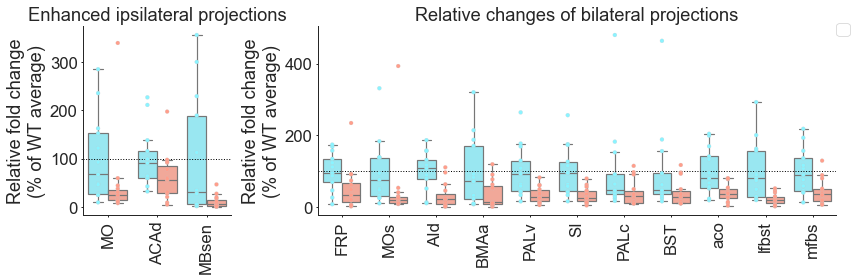

In [38]:
#plot bilateral changes individual regions enhanced ipsilateral and relative changes (Figure s4c, d)

fig, axes = plt.subplots(1, 2, figsize = (12, 4), gridspec_kw={'width_ratios': [1, 3.5]})


sns.stripplot (ax = axes[0], y = "Fold change (Tbr1/WT)", 
               x = "Structure", 
               hue = "Genotype",
               size = 4, 
               data = bilateral_compare_ipsi_U_bilateral_m,
               palette = ["#8BF3FF", "#FF9E8B"],
               dodge=True, jitter = False, split = True, linewidth = 0.2, edgecolor = "#C8C8C8")
sns.boxplot (ax = axes[0], y = "Fold change (Tbr1/WT)", 
               x = "Structure", 
               hue = "Genotype", 
               data = bilateral_compare_ipsi_U_bilateral_m,
               palette = ["#8BF3FF", "#FF9E8B"],
               dodge=True, fliersize=0)
axes[0].axhline(y=100, color='black', linewidth=1, linestyle=':')
axes[0].set_xticklabels (axes[0].get_xticklabels(), rotation = "vertical")
axes[0].set_ylabel ("Relative fold change\n(% of WT average)")
axes[0].set_title ("Enhanced ipsilateral projections")
axes[0].set_xlabel ("")
axes[0].legend_.remove()
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:0], labels[0:0], bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
sns.despine()

sns.stripplot (ax = axes[1], y = "Fold change (Tbr1/WT)", 
               x = "Structure", 
               hue = "Genotype",
               size = 4, 
               data = bilateral_compare_other_U_bilateral_m,
               palette = ["#8BF3FF", "#FF9E8B"],
               dodge=True, jitter = False, split = True, linewidth = 0.2, edgecolor = "#C8C8C8")
sns.boxplot (ax = axes[1], y = "Fold change (Tbr1/WT)", 
               x = "Structure", 
               hue = "Genotype", 
               data = bilateral_compare_other_U_bilateral_m,
               palette = ["#8BF3FF", "#FF9E8B"],
               dodge=True, fliersize=0)
axes[1].axhline(y=100, color='black', linewidth=1, linestyle=':')
plt.xticks (rotation = "vertical")
plt.ylabel ("Relative fold change\n(% of WT average)")
plt.title ("Relative changes of bilateral projections")
plt.xlabel ("")
ax1= plt.gca()
handles, labels = ax1.get_legend_handles_labels()
l = plt.legend(handles[6:], labels[6:], bbox_to_anchor=(1, 1.02), loc=2, borderaxespad=0.)
sns.despine()
plt.tight_layout()
plt.show()